In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/캡스톤

/content/drive/MyDrive/캡스톤


In [3]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 71.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 25.9 MB/s eta 0:00:00


In [4]:
!sudo apt-get install g++ openjdk-8-jdk python3-dev python3-pip curl
!pip install konlpy
!sudo apt-get install curl git
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
!pip install mecab-python3

Reading package lists... Done
Building dependency tree       
Reading state information... Done
g++ is already the newest version (4:9.3.0-1ubuntu2).
g++ set to manually installed.
python3-dev is already the newest version (3.8.2-0ubuntu2).
python3-dev set to manually installed.
curl is already the newest version (7.68.0-1ubuntu2.18).
The following additional packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libfontenc1 libgail-common libgail18 libgtk2.0-0
  libgtk2.0-bin libgtk2.0-common libxkbfile1 libxtst6 libxxf86dga1
  openjdk-8-jdk-headless openjdk-8-jre openjdk-8-jre-headless python-pip-whl
  python3-setuptools python3-wheel x11-utils
Suggested packages:
  gvfs openjdk-8-demo openjdk-8-source visualvm libnss-mdns
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic python-setuptools-doc mesa-utils
The following NEW packages will be installed:
  fonts-dejavu-core fonts-dejavu-e

<h1> 1. 필요한 라이브러리 임포트 </h1>

In [5]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt, Mecab
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

<h1> 2. Mecab으로 정제된 데이터 불러오기 </h1>
<li> review data -> 네이버 영화 리뷰 데이터 </li>
<li> shopping data -> 네이버 쇼핑 리뷰 데이터 </li>
<li> AI Hub data </li>

In [8]:
review_df = pd.read_csv('mecab_data.csv').drop(['index', 'id'], axis = 1)
review_df.head()

,document,label,sentence,preprocessed_sentence
0,아 더빙.. 진짜 짜증나네요 목소리,0,아 더빙 진짜 짜증나네요 목소리,아 더 빙 진짜 짜증 나 네요 목소리
1,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,흠 포스터 초딩 영화 줄 오버 연기 가볍 않
2,너무재밓었다그래서보는것을추천한다,0,너무재밓었다그래서보는것을추천한다,너무 재 밓었다그래서보는것을추천한다
3,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0,교도소 이야기구먼 솔직히 재미는 없다평점 조정,교도소 이야기 구먼 솔직히 재미 없 평점 조정
4,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,사이몬페그 익살 스런 연기 돋보였 영화 스파이더맨 늙 보이 했 커스틴 던스트 너무나...


In [9]:
shopping_df = pd.read_csv('shopping_review.csv')
shopping_df.head()

,ratings,reviews,sentence,preprocessed_sentence
0,5,배공빠르고 굿,배공빠르고 굿,배공 빠르 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,택배 엉망 이 네 용 저희 집 밑 층 말 없이 놔두 가
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다 바느질이 조금 엉...,아주 좋 바지 정말 좋 2 개 더 구매 했 이 가격 대박 입니다 바느질 조금 엉성 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다 전화...,선물 용 빨리 받 전달 했어야 하 상품 이 머그 컵 와서 당황 했 전화 했 바로 주...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,민트색상 예뻐요 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,민트 색상 예뻐요 옆 손잡이 거 용도 사용 되 ㅎㅎ


<h1> 3. 데이터 전처리 및 EDA</h1>

In [11]:
shopping_df['label'] = shopping_df['ratings'].apply(lambda x : 1 if x >= 4 else 0)
shopping_df['label'].value_counts()

0    99955
1    99953
Name: label, dtype: int64

In [12]:
shopping_df.head()

,ratings,reviews,sentence,preprocessed_sentence,label
0,5,배공빠르고 굿,배공빠르고 굿,배공 빠르 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,택배 엉망 이 네 용 저희 집 밑 층 말 없이 놔두 가,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다 바느질이 조금 엉...,아주 좋 바지 정말 좋 2 개 더 구매 했 이 가격 대박 입니다 바느질 조금 엉성 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다 전화...,선물 용 빨리 받 전달 했어야 하 상품 이 머그 컵 와서 당황 했 전화 했 바로 주...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,민트색상 예뻐요 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,민트 색상 예뻐요 옆 손잡이 거 용도 사용 되 ㅎㅎ,1


In [21]:
review_df = review_df[['sentence', 'preprocessed_sentence', 'label']]
shopping_df = shopping_df[['sentence', 'preprocessed_sentence', 'label']]

train_data = pd.concat([review_df, shopping_df], axis = 0)
train_data = train_data.sample(frac = 1).reset_index(drop = True)

<ipython-input-22-3bc463e21055>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Text(0.5, 1.0, 'label distribution of data')

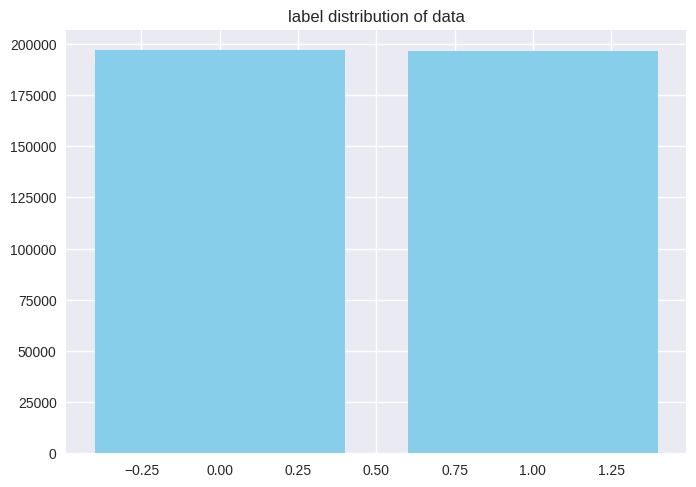

In [22]:
## 클래스 라벨 비율 분포 확인
import matplotlib.pyplot as plt
plt.style.use('seaborn')

plt.bar(train_data['label'].value_counts().index, train_data['label'].value_counts(), color = 'skyblue')
plt.title('label distribution of data')

Text(0.5, 1.0, 'document length distribution')

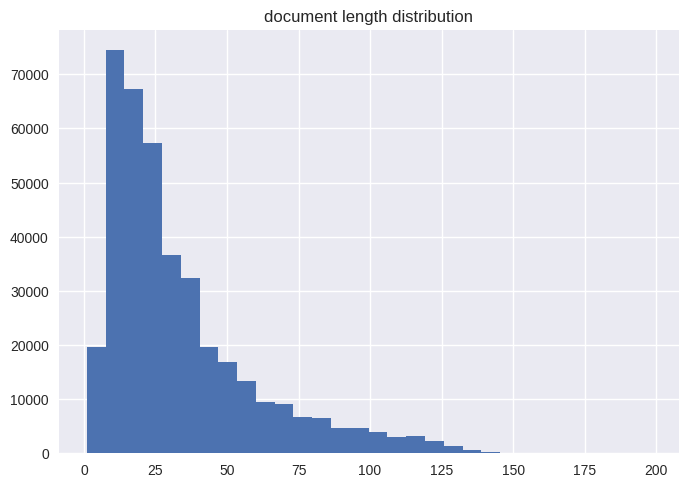

In [27]:
document_length = [len(x) for x in train_data['preprocessed_sentence'].astype(str)]
plt.hist(document_length, bins = 30)
plt.title('document length distribution')

<h1> 4. 텍스트 데이터 to 벡터화

In [30]:
from sklearn.model_selection import train_test_split

train_X, test_X, y_train, y_test = train_test_split(train_data['preprocessed_sentence'], train_data['label'],
                                                    test_size = 0.25, random_state = 2023, stratify = train_data['label'])

train_X.shape, test_X.shape, y_train.shape, y_test.shape

((295171,), (98391,), (295171,), (98391,))

In [32]:
train_X[0]

'일 점 아깝 ㅋㅋ 서우 연기 진짜 못 봐 주 썰'

In [34]:
X_train = []
X_test = []

for sentence in tqdm(train_X):
    tokenized_sentence = str(sentence).split(' ')
    X_train.append(tokenized_sentence)

for sentence in tqdm(test_X):
    tokenized_sentence = str(sentence).split(' ')
    X_test.append(tokenized_sentence)

100%|██████████| 98391/98391 [00:00<00:00, 448716.87it/s]


In [35]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

print(tokenizer.word_index)

{'하': 1, '좋': 2, '영화': 3, '이': 4, '한': 5, '있': 6, '안': 7, '보': 8, '잘': 9, '너무': 10, '들': 11, '했': 12, '없': 13, '같': 14, '구매': 15, '거': 16, '배송': 17, '되': 18, '것': 19, '않': 20, '다': 21, '주': 22, '먹': 23, '합니다': 24, '재': 25, '나': 26, '해': 27, '해서': 28, '정말': 29, '생각': 30, '적': 31, '쓰': 32, '봤': 33, '그냥': 34, '좀': 35, '수': 36, '더': 37, '할': 38, '진짜': 39, '때': 40, '게': 41, '사용': 42, '듯': 43, '입니다': 44, '인': 45, '개': 46, '점': 47, '아니': 48, '받': 49, '해요': 50, 'ㅋㅋ': 51, '제품': 52, '번': 53, '재밌': 54, '만족': 55, '많이': 56, '말': 57, '가격': 58, '주문': 59, '싶': 60, '내': 61, '못': 62, '최고': 63, '지': 64, '알': 65, 'ㅠㅠ': 66, '1': 67, '이런': 68, '맛': 69, '중': 70, '사': 71, '별로': 72, '그': 73, '왜': 74, '하나': 75, '연기': 76, '함': 77, '작': 78, '넘': 79, '평점': 80, '맞': 81, '괜찮': 82, '다른': 83, 'ㅋㅋㅋ': 84, '왔': 85, '일': 86, '사이즈': 87, '정도': 88, '두': 89, '세요': 90, '사람': 91, '2': 92, '다시': 93, '많': 94, '줄': 95, '빠르': 96, '샀': 97, '데': 98, '뭐': 99, '인데': 100, '맛있': 101, '시간': 102, '만들': 103, '포장': 104, '가': 105, '완전': 106, 

In [40]:
threshold = 10
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 71156
등장 빈도가 9번 이하인 희귀 단어의 수: 56215
단어 집합에서 희귀 단어의 비율: 79.00247343864186
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.455244073106826


In [41]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 14942


In [42]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [43]:
print(X_train[:3])

[[14135, 138, 47], [10400, 437, 11200, 15, 28, 3562, 4689, 314, 1925, 4544, 18, 860, 4, 21, 8035, 265, 629, 1, 90], [2528]]


In [44]:
y_train = np.array(y_train)
y_test = np.array(y_test)

<h3> 빈 샘플 제거하기 </h3>

In [45]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
X_train = np.delete(X_train, drop_train, axis = 0)
y_train = np.delete(y_train, drop_train, axis = 0)
print(len(X_train))
print(len(y_train))

294606
294606


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 12.242136955798593


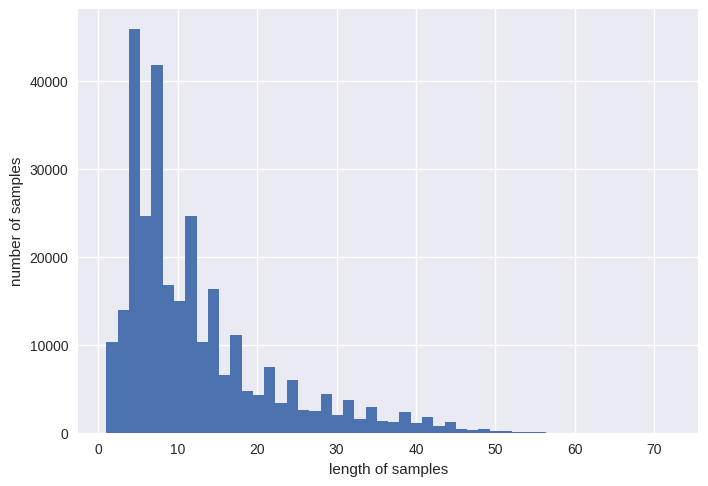

In [46]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [47]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [49]:
max_len = 72
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 72 이하인 샘플의 비율: 100.0


In [50]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

<h1> 5. 모델 돌리기(LSTM) </h1>

In [58]:
y_train = np.array(y_train).astype(np.int8)
y_test = np.array(y_test).astype(np.int8)

In [70]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 128
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
#mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['acc'])
#history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_data=[X_test, y_test])
history = model.fit(X_train, y_train, epochs = 30, batch_size = 128, validation_split = 0.2)

Epoch 1/30
1842/1842 [==============================] - 49s 26ms/step - loss: 0.3410 - acc: 0.8550 - val_loss: 0.2996 - val_acc: 0.8769
Epoch 2/30
1842/1842 [==============================] - 15s 8ms/step - loss: 0.2670 - acc: 0.8919 - val_loss: 0.2949 - val_acc: 0.8819
Epoch 3/30
1842/1842 [==============================] - 14s 7ms/step - loss: 0.2309 - acc: 0.9082 - val_loss: 0.2964 - val_acc: 0.8794
Epoch 4/30
1842/1842 [==============================] - 13s 7ms/step - loss: 0.1984 - acc: 0.9225 - val_loss: 0.3223 - val_acc: 0.8765
Epoch 5/30
1842/1842 [==============================] - 13s 7ms/step - loss: 0.1678 - acc: 0.9361 - val_loss: 0.3593 - val_acc: 0.8726
Epoch 6/30
1842/1842 [==============================] - 13s 7ms/step - loss: 0.1411 - acc: 0.9470 - val_loss: 0.4180 - val_acc: 0.8696
Epoch 7/30
1842/1842 [==============================] - 12s 6ms/step - loss: 0.1190 - acc: 0.9559 - val_loss: 0.4654 - val_acc: 0.8677
Epoch 8/30
1842/1842 [==============================] 

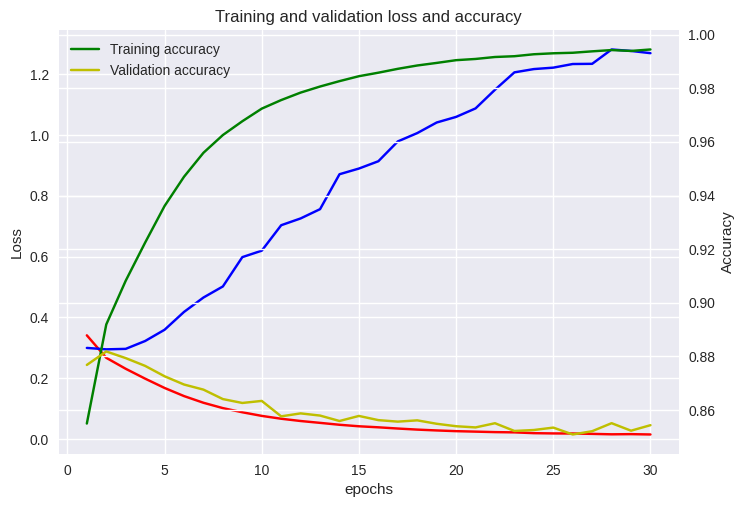

In [74]:
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
# 그래프 생성
fig, ax1 = plt.subplots()

ax1.plot(epochs, loss, 'r', label = 'Training loss')
ax1.plot(epochs, val_loss, 'b', label = 'Validation loss')

ax1.set_xlabel('epochs')
ax1.set_ylabel('Loss')

ax2 = ax1.twinx()
ax2.plot(epochs, accuracy, 'g', label = 'Training accuracy')
ax2.plot(epochs, val_accuracy, 'y', label = 'Validation accuracy')

ax2.set_xlabel('epochs')
ax2.set_ylabel('Accuracy')

plt.title('Training and validation loss and accuracy')
plt.legend()
plt.show()